# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [ ]:
#The goal is to identify and quantify the key factors that influence the pricing of used cars. 
#This involves constructing a predictive model that uses various features of a car, such as make, model, age, mileage, condition, and additional attributes, to estimate its price.
#The task will involve exploratory data analysis (EDA) to identify relevant features, followed by feature selection, and the application of regression techniques to model 
#the relationship between these features and the car's price. 
#The insights gained from this model will inform the dealership's pricing strategy 
#by highlighting the attributes that most significantly affect used car prices.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector


import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("data/vehicles.csv")
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [4]:
df.isna().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [3]:
df_drop = df.dropna()
df_drop.set_index("id", inplace=True)
df_drop.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
id,,,,,,,,,,,,,,,,,
7305672709,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,68472.0,clean,automatic,1GCWGAFP8J1309579,rwd,full-size,van,white,al
7305672266,auburn,0,2019.0,chevrolet,express cargo van,like new,6 cylinders,gas,69125.0,clean,automatic,1GCWGAFP4K1214373,rwd,full-size,van,white,al
7305672252,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,66555.0,clean,automatic,1GCWGAFPXJ1337903,rwd,full-size,van,white,al
7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [18]:
X = df_drop.drop('price',axis = 1)
y = df_drop['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22, test_size=.3)
model_list = []
mse_list = []

In [20]:
#determining some of the features/parameters to explore
poly_ordinal_ohe = make_column_transformer((PolynomialFeatures(degree = 3), make_column_selector(dtype_include=np.number)),
                                           (OrdinalEncoder(categories = [['salvage', 'new', 'fair', 'like new', 'good', 'excellent'],
                                                                               ['other', 'manual', 'automatic'],
                                                                               ['other', 'electric', 'hybrid', 'diesel', 'gas'],
                                                                               ['parts only', 'missing', 'lien', 'salvage', 'rebuilt', 'clean'],
                                                                               ['rwd', 'fwd', '4wd'],
                                                                               ['sub-compact', 'compact', 'mid-size', 'full-size']]), 
                                                   ['condition', 'transmission', 'fuel', 'title_status', 'drive', 'size']))

selector_pipe = Pipeline([('transformer', poly_ordinal_ohe), 
                          ('scale', StandardScaler()),
                          ('selector', SequentialFeatureSelector(LinearRegression())),
                         ('model', LinearRegression())])

param_dict = {'selector__n_features_to_select': [2, 3, 4, 5, 6, 7, 8, 9, 10]}
selector_grid = GridSearchCV(selector_pipe, param_grid=param_dict)
selector_grid.fit(X_train, y_train)
train_preds = selector_grid.predict(X_train)
test_preds = selector_grid.predict(X_test)
selector_train_mse = mean_squared_error(y_train, train_preds)
selector_test_mse = mean_squared_error(y_test, test_preds)

print(f'Train MSE: {selector_train_mse}')
print(f'Test MSE: {selector_test_mse}')

model_list.append("Grid Model")
mse_list.append(selector_test_mse)

best_estimator = selector_grid.best_estimator_
best_selector = best_estimator.named_steps['selector']
best_model = selector_grid.best_estimator_.named_steps['model']
feature_names = X_train.columns[best_selector.get_support()]
coefs = best_model.coef_

print(best_estimator)
print(f'Features from best selector: {feature_names}.')
print('Coefficient values: ')
print('===================')
results = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs.T})

Train MSE: 117701203.13123596
Test MSE: 116903253.23582533
Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=3),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001770129C990>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['salvage',
                                                                              'new',
                                                                              'fair',
                                                                              'like '
                                                                              'new',
                                                                              'good',
                                

In [21]:
#This is a test if you can have multiple features in an ordinal encoder 
#features to consider: condition, transmission, fuel, title_status, drive, size
ordinal_ohe_transformer = make_column_transformer((OrdinalEncoder(categories = [['salvage', 'new', 'fair', 'like new', 'good', 'excellent'],
                                                                               ['other', 'manual', 'automatic'],
                                                                               ['other', 'electric', 'hybrid', 'diesel', 'gas'],
                                                                               ['parts only', 'missing', 'lien', 'salvage', 'rebuilt', 'clean'],
                                                                               ['rwd', 'fwd', '4wd'],
                                                                               ['sub-compact', 'compact', 'mid-size', 'full-size']]), 
                                                   ['condition', 'transmission', 'fuel', 'title_status', 'drive', 'size']),
                                                    remainder='passthrough')

In [22]:
pipe_2 = Pipeline([('transformer', ordinal_ohe_transformer), 
                  ('linreg', LinearRegression())])
pipe_2.fit(X_train[['year', 'condition', 'transmission', 'fuel', 'title_status', 'drive', 'size']], y_train)
pred_train = pipe_2.predict(X_train[['year', 'condition', 'transmission', 'fuel', 'title_status', 'drive', 'size']])
pred_test = pipe_2.predict(X_test[['year', 'condition', 'transmission', 'fuel', 'title_status', 'drive', 'size']])
pipe_2_train_mse = mean_squared_error(y_train, pred_train)
pipe_2_test_mse = mean_squared_error(y_test, pred_test)

model_list.append("Transformer_Linear")
mse_list.append(pipe_2_test_mse)

print(pipe_2.named_steps)
print(f'Train MSE: {pipe_2_train_mse: .2f}')
print(f'Test MSE: {pipe_2_test_mse: .2f}')
pipe_2

{'transformer': ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder',
                                 OrdinalEncoder(categories=[['salvage', 'new',
                                                             'fair', 'like new',
                                                             'good',
                                                             'excellent'],
                                                            ['other', 'manual',
                                                             'automatic'],
                                                            ['other',
                                                             'electric',
                                                             'hybrid', 'diesel',
                                                             'gas'],
                                                            ['parts only',
                                                             'm

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['salvage',
                                                                              'new',
                                                                              'fair',
                                                                              'like '
                                                                              'new',
                                                                              'good',
                                                                              'excellent'],
                                                                             ['other',
                                                                              'manual',
                                                                              'automatic'],
                                                                             ['other',
                                                                              'electric',
                                                                              'hybrid',
                                                                              'diesel',
                                                                              'gas'],
                                                                             ['parts '
                                                                              'only',
                                                                              'missing',
                                                                              'lien',
                                                                              'salvage',
                                                                              'rebuilt',
                                                                              'clean'],
                                                                             ['rwd',
                                                                              'fwd',
                                                                              '4wd'],
                                                                             ['sub-compact',
                                                                              'compact',
                                                                              'mid-size',
                                                                              'full-size']]),
                                                  ['condition', 'transmission',
                                                   'fuel', 'title_status',
                                                   'drive', 'size'])])),
                ('linreg', LinearRegression())])

In [23]:
features = ['year', 'condition', 'transmission', 'fuel', 'odometer', 'title_status', 'drive', 'size']

In [24]:
#Model using a transformer containing PolynomialFeatures and OrdinalEncoder, and LinearRegression
train_mses = []
test_mses = []
poly_ordinal_ohe = make_column_transformer((PolynomialFeatures(degree = 2), make_column_selector(dtype_include=np.number)),
                                           (OrdinalEncoder(categories = [['salvage', 'new', 'fair', 'like new', 'good', 'excellent'],
                                                                               ['other', 'manual', 'automatic'],
                                                                               ['other', 'electric', 'hybrid', 'diesel', 'gas'],
                                                                               ['parts only', 'missing', 'lien', 'salvage', 'rebuilt', 'clean'],
                                                                               ['rwd', 'fwd', '4wd'],
                                                                               ['sub-compact', 'compact', 'mid-size', 'full-size']]), 
                                                   ['condition', 'transmission', 'fuel', 'title_status', 'drive', 'size']))
pipe = Pipeline([('transformer', poly_ordinal_ohe), ('linreg', LinearRegression())])

pipe.fit(X_train[features], y_train)
p1 = pipe.predict(X_train[features])
p2 = pipe.predict(X_test[features])
train_mses.append(mean_squared_error(y_train, p1))
test_mses.append(mean_squared_error(y_test, p2))

model_list.append("Transformer_Linear_Selected_Features")
mse_list.append(mean_squared_error(y_test, p2))

print(train_mses)
print(test_mses)
pipe

[121554990.6645169]
[120214966.16384676]


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001770141FD50>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['salvage',
                                                                              'new',
                                                                              'fair',
                                                                              'like '
                                                                              'new',
                                                                              'good',
                                                                              'excellent'],
                                                                             ['other',
                                                                              'manual',
                                                                              'automatic'],
                                                                             ['other',
                                                                              'electric',
                                                                              'hybrid',
                                                                              'diesel',
                                                                              'gas'],
                                                                             ['parts '
                                                                              'only',
                                                                              'missing',
                                                                              'lien',
                                                                              'salvage',
                                                                              'rebuilt',
                                                                              'clean'],
                                                                             ['rwd',
                                                                              'fwd',
                                                                              '4wd'],
                                                                             ['sub-compact',
                                                                              'compact',
                                                                              'mid-size',
                                                                              'full-size']]),
                                                  ['condition', 'transmission',
                                                   'fuel', 'title_status',
                                                   'drive', 'size'])])),
                ('linreg', LinearRegression())])

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [ ]:
#at the bare minimum, of the features of type int and float in the dataset, the 'year' feature has the highest correlation
#to the 'price' feature, meaning that it is one of the features that should be considered when calculating price

In [ ]:
#Three models were created in order to test different parameters and efficiency. 

In [ ]:
#The model I've decided to work with is the model involving GridSearchCV, as not only does it have the lowest MSE among
#the created models, but it also provides a list of features that are considered the most important for predicting price.

Text(0, 0.5, 'Values')

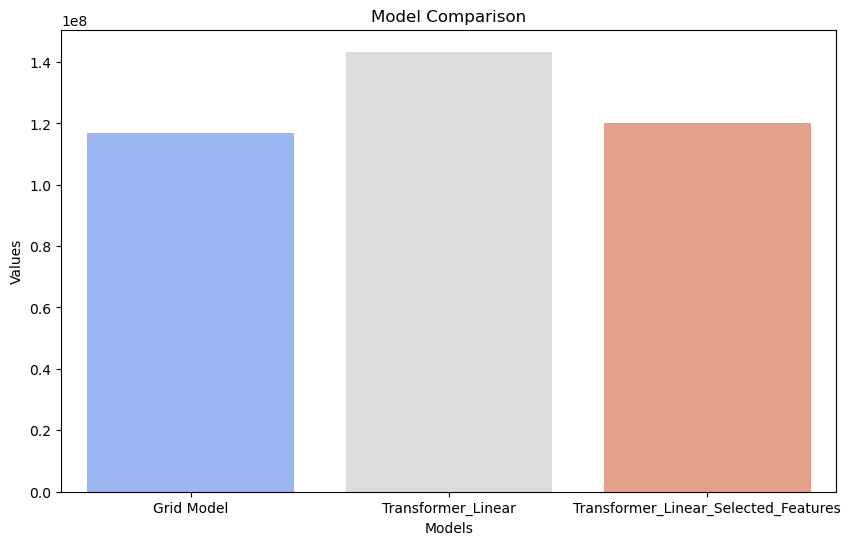

In [25]:
df = pd.DataFrame({'Model': model_list, 'Value': mse_list})
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Value', data=df, palette='coolwarm')# Adding title and labels
plt.title('Model Comparison')
plt.xlabel('Models')
plt.ylabel('Values')

In [ ]:
#Based off this bar chart, the Grid Model has the lowset MSE and so I've decided to use this model

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

In [ ]:
#Before I get into the primary findings, I want to provide some insight in how I reached these findings.

In [ ]:
#The dataset that was provided contained numerous missing values, and due to the nature of the missing data,
#I decided to remove all the entries with missing values. 

In [ ]:
#After creating and testing various models, the model I decided to focus on was one that inovlved GridSearchCV, Pipeline, 
#make_column_transformer, PolynomialFeatures, OrdinalEncoder, StandardScaler, SequentialFeatureSelector, and LinearRegression.

In [ ]:
#Using this model, I was able to narrow down the provided features to the 10 most important
#in order of importance, the feature are: year, model, fuel, odometer, title_status, transmission, drive, size, paint_color, and state.

In [ ]:
#While these are the features that I've found to be most important in predicting price, I suggest that more research be done,
#especially with a more coherent dataset given that the one provided had a lot of missing data.
#Having a dataset with less missing data could help find more accurate results of features involved in predicting price.